# Import Libraries
we import the libraries that we are going to use in this

In [93]:
import keras
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras.datasets import mnist
from keras.utils import plot_model
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from sklearn.metrics import adjusted_rand_score

We download the Mnist dataset and put the data in train and test sets

In [94]:
(images_train, label_train),(images_test,label_test) = mnist.load_data()

We print the shape of the train and test

In [95]:
#print shape of data
print(images_train.shape)
print(label_train.shape)
print(images_test.shape)
print(label_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


We randomly print 5 images from the Mnist dataset (Mnist dataset has 10 calsses)

[25737, 59625, 12867, 27005, 41389]


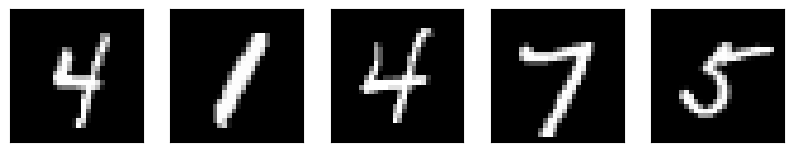

In [96]:
import random
class_names = ['0', '1', '2', '3', '4',
               '5', '6', '7', '8', '9']
plt.figure(figsize=(10,10))

rand_list=[]
for i in range(5):
    rand_list.append(random.randint(0,60000))
print(rand_list)

j=0
for i in rand_list:
  plt.subplot(5,5,j+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(images_train[i])
  j=j+1
plt.show()

# Preprocess

We Normalize the dataset to be able to perform better on it.For the pixels the highest value possible is 255. With that in mind if the pixels are divided by 255 all of the pixels will be in the range of 0 to 1. This method is applied here to normalize the dataset.

In [97]:
train_images = images_train.astype('float32')/255
test_images = images_test.astype('float32')/255

The input into the AutoEncoder is seen as 784 flattend array. To achive this the dataset is reshaped to this dimension so that it can enter the input layer of AutoEncoder. The shape of the train and test set is printed to demonstrate the operation conducted on the dataset.

In [98]:
train_images = train_images.reshape((len(train_images), np.prod(train_images.shape[1:])))
test_images = test_images.reshape((len(test_images), np.prod(test_images.shape[1:])))
print(train_images.shape)
print(test_images.shape)

(60000, 784)
(10000, 784)


# AutoEncoder

First an activation function named Coustom should be defined. In the AutoEncoder the first two hidden layers of the Encoder use both the relu and tanh activation function. To be able to perform this operation a new function is defined where the input is first passed into the relu activation function and the output of relu is passed into tanh activation function. In the end the function returns the output of tanh.

In [99]:
def custom(x):
  relu = tf.nn.relu(x)
  tanh = tf.nn.tanh(relu)
  return tanh

The model is made using keras layers and the architecture shown in the article. As it could be seen in the code bellow the first two layers of the encoder (encoder_layer_1 and encoder_layer_2) use the activation function defined in the code above. The rest of the layers ,however, use the normal tanh and sigmoid activation functions. The latent_layer doesn't have any activation functions according to the article.

Also L2 regularization is applied to the layers using keras libraries regulizers function. The balancing factor for regularization is put to 0.00001.

In [100]:
#encoder and decoder
input_img = Input(shape = (784,))
encoder_layer_1 = Dense(512, activation = custom, kernel_regularizer=regularizers.l2(0.00001))(input_img)
encoder_layer_2 = Dense(128, activation = custom, kernel_regularizer=regularizers.l2(0.00001))(encoder_layer_1)
encoder_layer_3 = Dense(32, activation = "tanh", kernel_regularizer=regularizers.l2(0.00001))(encoder_layer_2)
#latent space
latent_layer = Dense(10, kernel_regularizer=regularizers.l2(0.00001))(encoder_layer_3)
decoder_layer_1 = Dense(32, activation = "tanh", kernel_regularizer=regularizers.l2(0.00001))(latent_layer)
decoder_layer_2 = Dense(128, activation = "tanh", kernel_regularizer=regularizers.l2(0.00001))(decoder_layer_1)
decoder_layer_3 = Dense(512, activation = "tanh", kernel_regularizer=regularizers.l2(0.00001))(decoder_layer_2)
decoder_layer_4 = Dense(784, activation = "sigmoid", kernel_regularizer=regularizers.l2(0.00001))(decoder_layer_3)

THe Autoencoder model is build with input_img being the input layer and decoder_layer_4 being the output layer

In [101]:
#autoencoder model
autoencoder = Model(input_img, decoder_layer_4)
autoencoder.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_24 (Dense)            (None, 512)               401920    
                                                                 
 dense_25 (Dense)            (None, 128)               65664     
                                                                 
 dense_26 (Dense)            (None, 32)                4128      
                                                                 
 dense_27 (Dense)            (None, 10)                330       
                                                                 
 dense_28 (Dense)            (None, 32)                352       
                                                                 
 dense_29 (Dense)            (None, 128)               4224

For better undrestanding of the autoencoder model the graphatical representation of the model is displayed

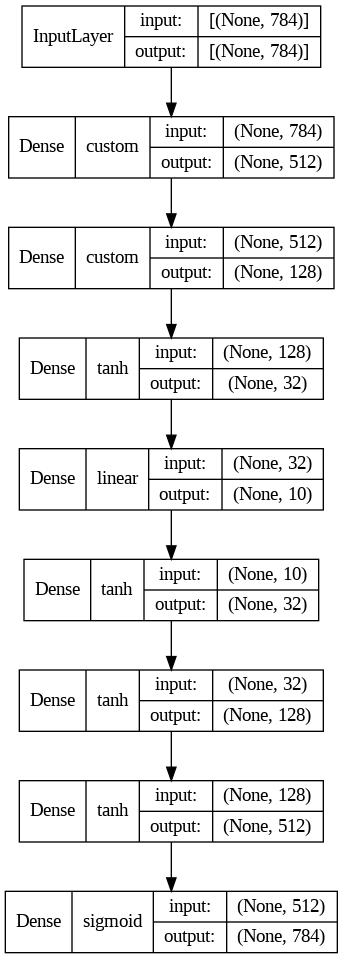

In [102]:
plot_model(autoencoder, to_file='model_plot.png', show_shapes=True, show_layer_names=False, show_layer_activations=True)

The encoder model is build with input_img being the input layer and latent_layer being the output layer

In [103]:
#encoder model
encoder = Model(input_img, latent_layer)
encoder.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_24 (Dense)            (None, 512)               401920    
                                                                 
 dense_25 (Dense)            (None, 128)               65664     
                                                                 
 dense_26 (Dense)            (None, 32)                4128      
                                                                 
 dense_27 (Dense)            (None, 10)                330       
                                                                 
Total params: 472042 (1.80 MB)
Trainable params: 472042 (1.80 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


For better undrestanding of the encoder model the graphatical representation of the model is displayed

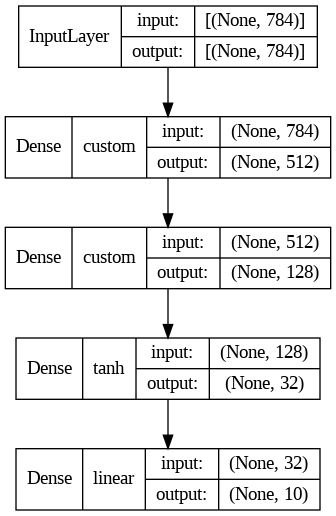

In [104]:
plot_model(encoder, to_file='model_plot.png', show_shapes=True, show_layer_names=False, show_layer_activations=True)

The autoencoder model is trained with the optimizer of adam and the loss function of MSE. Keep in mind that the regularization term is applied in the layers.

In [105]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

The learning rate for the adam optimizer starts at 0.003 and decreases with the number of epochs during training. In the function learning_rate_schedule we apply this condition with the learning rate decay of 0.9 per epoch.

In [106]:
def learning_rate_schedule(epoch):
    initial_lr = 0.003  # Initial learning rate
    decay = 0.9  # Decay factor
    lr = initial_lr * (decay ** epoch)
    return lr

In [107]:
lr_scheduler = LearningRateScheduler(learning_rate_schedule)

We fit the autoencoder with 20 epochs. We put the learning rate schedule in the callbscks.

In [108]:
history = autoencoder.fit(train_images, train_images, epochs =20, shuffle = True, validation_data = (test_images, test_images), callbacks=[lr_scheduler])

Epoch 1/20
1875/1875 [==============================] - 17s 8ms/step - loss: 0.0508 - val_loss: 0.0416 - lr: 0.0030
Epoch 2/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0399 - val_loss: 0.0377 - lr: 0.0027
Epoch 3/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0365 - val_loss: 0.0359 - lr: 0.0024
Epoch 4/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0353 - val_loss: 0.0346 - lr: 0.0022
Epoch 5/20
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0345 - val_loss: 0.0340 - lr: 0.0020
Epoch 6/20
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0337 - val_loss: 0.0330 - lr: 0.0018
Epoch 7/20
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0328 - val_loss: 0.0320 - lr: 0.0016
Epoch 8/20
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0322 - val_loss: 0.0317 - lr: 0.0014
Epoch 9/20
1875/1875 [==============================] - 9s 5ms/step - loss

We plot the training and validation loss of the autoencoder model

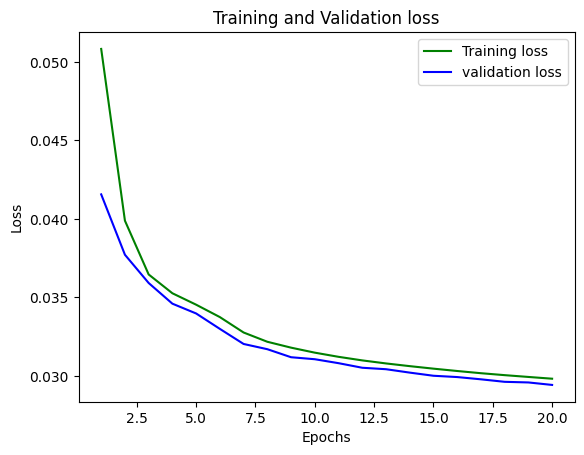

In [109]:
# Plot Training and validation loss
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

To see how the autoencoder model is performing, the test set is passed into the autoencoder and the output is saved

In [110]:
encoded_img = autoencoder.predict(test_images)

313/313 [==============================] - 1s 2ms/step


Now the output of the autoencoder and the test set is compared. As it could be seen in the pictures bellow the autoencoder has done a decent job at reconstructing the test set. So it can be concluded that the autoencoder has decent accuracy

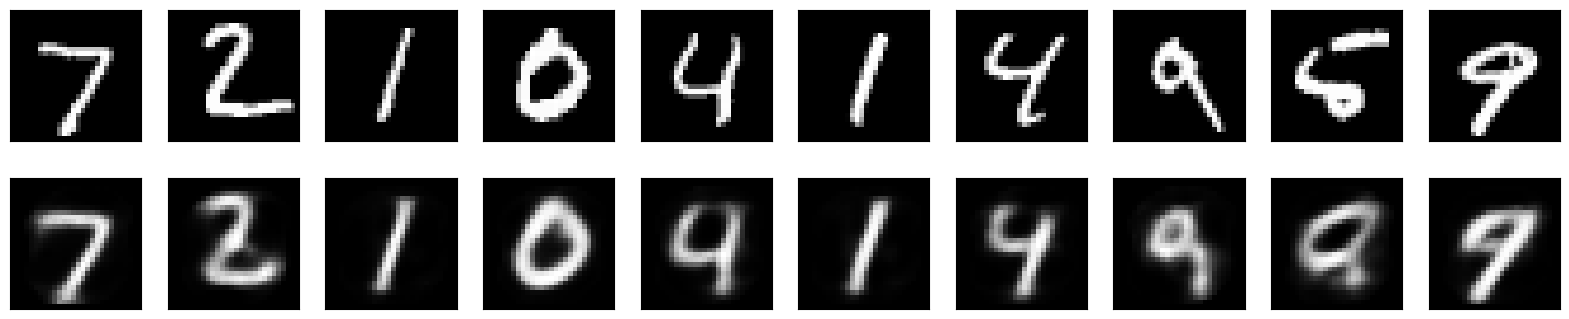

In [111]:
#Display actual test images and images made with model
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original data
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(encoded_img[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Clustering

For classification the KNN algorithm is used. The dataset used is Mnist which has 10 classes. Considering this point the number of neighbors for KNN is set to 10. First the raw model is build without using the autoencoder.

In [112]:
k_neighbors = 10
knn_classifier_raw = KNeighborsClassifier(n_neighbors=k_neighbors)
knn_classifier_raw.fit(train_images, label_train)

KNeighborsClassifier(n_neighbors=10)

The shape of the input for the raw KNN model is shown bellow

In [113]:
train_images.shape

(60000, 784)

To obtain the accuracy of the raw KNN model the test set is passed into the algorithm

In [114]:
accuracy = knn_classifier_raw.score(test_images, label_test)
print(f"KNN Classifier Accuracy (raw model) : {accuracy}")

KNN Classifier Accuracy (raw model) : 0.9665


To have a better undrestanding of the model, the ARI score of the model is calculated. The Adjusted Rand Index (ARI) is a measure used to assess the similarity between two clustering results, while correcting for chance.

In [115]:
predicted_labels = knn_classifier_raw.predict(test_images)

ari_score = adjusted_rand_score(label_test, predicted_labels)

print(f"Adjusted Rand Index (raw model) : {ari_score}")

Adjusted Rand Index (raw model) : 0.9268523085600376


Now the KNN model is build but this time the encoder is used to lower the dimension of the input. So the train and test sets are passed into the encoder and the result is saved to be used in the KNN algorithm

In [116]:
encoded_train = encoder.predict(train_images)
encoded_test = encoder.predict(test_images)

313/313 [==============================] - 1s 2ms/step


THe shape of the KNN model is shown bellow.

In [117]:
encoded_train.shape

(60000, 10)

Now the KNN model which uses the encoder is built. For the number of neighbors number 10 is used to be identical with the raw KNN model.

In [118]:
k_neighbors = 10
knn_classifier = KNeighborsClassifier(n_neighbors=k_neighbors)
knn_classifier.fit(encoded_train, label_train)

KNeighborsClassifier(n_neighbors=10)

THe accuracy of the KNN model is measured

In [119]:
accuracy = knn_classifier.score(encoded_test, label_test)
print(f"KNN Classifier Accuracy (with encoder) : {accuracy}")

KNN Classifier Accuracy (with encoder) : 0.9365


THe ARI if the KNN model is calculated to give a better undrestanding of the models performance

In [120]:
predicted_labels = knn_classifier.predict(encoded_test)

ari_score = adjusted_rand_score(label_test, predicted_labels)

print(f"Adjusted Rand Index (with encoder) : {ari_score}")

Adjusted Rand Index (with encoder) : 0.8684588016350171
